In [5]:
from quantum_electron import FullModel, PotentialVisualization, package_versions
from quantum_electron.initial_condition import InitialCondition
import numpy as np
from matplotlib import pyplot as plt

package_versions()

quantum_electron 0.2.0
numpy 1.24.2
scipy 1.11.4
matplotlib 3.7.1


# Construct a potential

In [4]:
# Note that the units of x and y are implicitly assumed as microns
x = np.linspace(-2.5, 2.5, 401)
y = np.linspace(-2.5, 2.5, 401)

micron = 1e-6

X, Y = np.meshgrid(x, y)
X *= micron
Y *= micron

# parabolic_confinement = 0.01*(- X ** 2 - 8 * Y ** 2) / micron ** 2 - 2 * 0.01* (X ** 4) / micron ** 4
parabolic_confinement = 0.01*(- X ** 2 - Y ** 2) / micron ** 2 

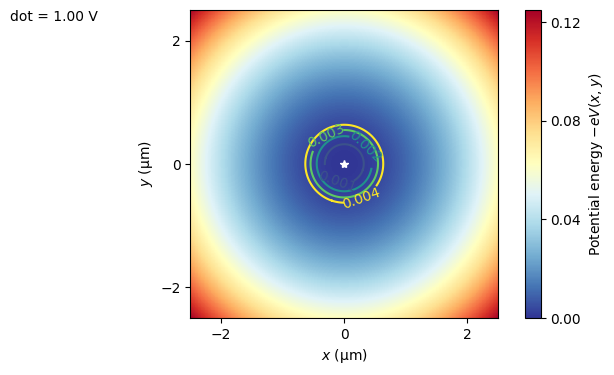

In [5]:
potential_dict = {"dot" : parabolic_confinement, 
                  "xlist" : x, 
                  "ylist" : y}

# Let's apply these voltages to the corresponding electrodes in potential_dict
voltages = {"dot" : 1.0}

p = PotentialVisualization(potential_dict, voltages)
p.plot_potential_energy(dxdy=(5, 5))

In [32]:
options = {"f0" : 4e9, # Resonance frequency for the resonator (only used for solving motional frequencies)
           "Z0" : 50.0, # Resonator impedance (only used for solving motional frequencies)
           "include_screening" : False, # Include screening of electron-electron interactions due to thin film.
           "screening_length" : 2e-6, # Typically helium thickness.
           "potential_smoothing" : 1e-4, # Numerical smoothing of the splines (gets rid of some noise, can introduce artifacts)
           "remove_unbound_electrons" : False, # Removes electrons if they shot outside the solution box.
           "remove_bounds" : None, # Sets which electrons should be removed if above is True.
           "trap_annealing_steps" : [1.0] * 4, # List of annealing temperatures, length determines the number of steps
           "max_x_displacement" : 0.1e-6, # Maximum x-displacement of solved electron positions during annealing.
           "max_y_displacement" : 0.1e-6} # Maximum y-displacement of solved electron positions during annealing.

# Comparing initial conditions

In [35]:
n_electrons = 50
min_spacing = 0.1 # micron

ic = InitialCondition(potential_dict, voltages)
circular = ic.make_circular(n_electrons=n_electrons, min_spacing=min_spacing)
rectangular = ic.make_rectangular(n_electrons=n_electrons, dxdy=(2, 2), n_rows=5)
chem_potential = ic.make_by_chemical_potential(max_electrons=n_electrons, chemical_potential=0.01, min_spacing=min_spacing)

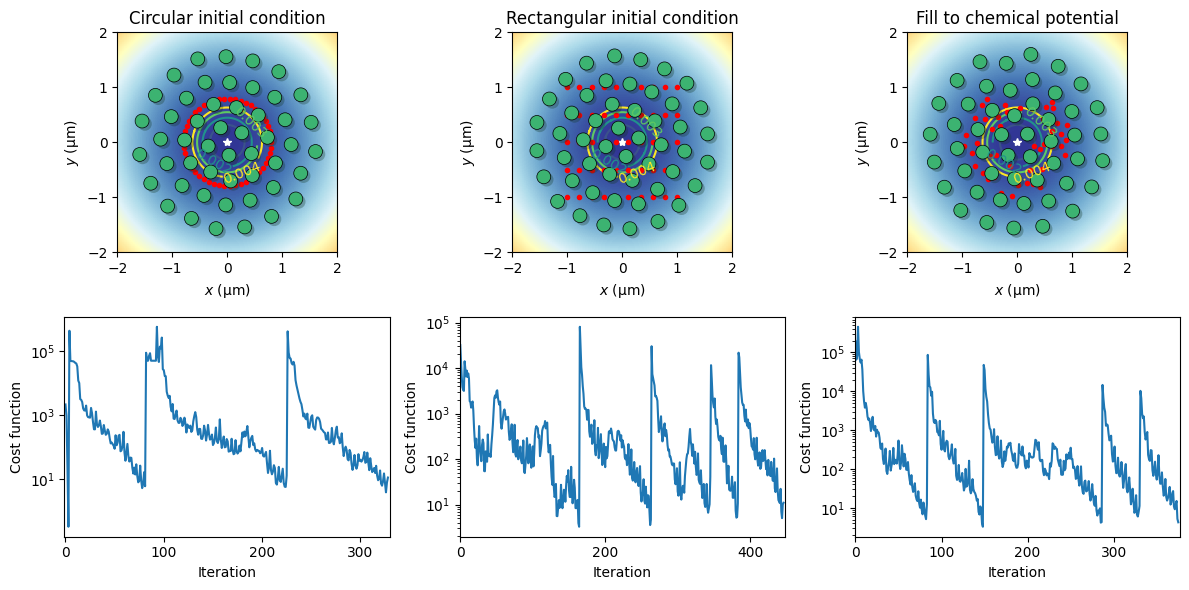

In [36]:
fig, ax = plt.subplots(2, 3, figsize=(4*3, 6))
ax = ax.flatten()

f = FullModel(potential_dict, voltages, **options)

for k, init_cond in enumerate([circular, rectangular, chem_potential]):
    res = f.get_electron_positions(n_electrons=len(init_cond) // 2, electron_initial_positions=init_cond, verbose=False)
    # print(f.count_electrons_in_dot(res['x'], trap_bounds_x=(-2e-6, 2e-6), trap_bounds_y=(-2e-6, 2e-6)))
    f.plot_potential_energy(dxdy=(4, 4), ax=ax[k], plot_contours=True, print_voltages=False)
    ax[k].plot(init_cond[::2]*1e6, init_cond[1::2]*1e6, '.r')
    f.plot_electron_positions(res, ax=ax[k])

    f.plot_convergence(ax=ax[k+3])

ax[0].set_title("Circular initial condition")
ax[1].set_title("Rectangular initial condition")
ax[2].set_title("Fill to chemical potential")
fig.tight_layout()

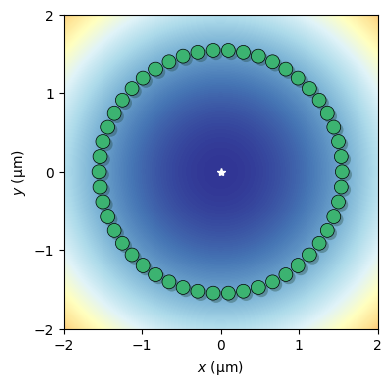

In [10]:
amim = f.animate_convergence(dxdy=(4, 4), frame_interval_ms=25)

In [11]:
f.show_animation(amim)